### Part 1: Build a classification model using text data

Import the text data, vectorize the clickbait headline column into an X matrix. 

In [ ]:
!pip install aimodelshare

In [ ]:
!pip install mglearn

In [ ]:
import aimodelshare as ai
X_train, X_test, y_train_labels, y_test_labels, example_data, lstm_model, lstm_model2 = ai.import_quickstart_data("clickbait")

In [4]:
y_train = y_train_labels.apply(lambda x: 0 if x == 'not clickbait' else 1)
y_test = y_test_labels.apply(lambda x: 0 if x == 'not clickbait' else 1)

#### Approach 1: Bag of Words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

In [6]:
# vectorize the clickbait headline column into an X matrix.
countvect = CountVectorizer(min_df = 3, stop_words = 'english').fit(X_train)
X_count_train = countvect.transform(X_train)
X_count_test = countvect.transform(X_test)

In [7]:
logit_1 = LogisticRegression().fit(X_count_train,y_train)
print("The Mean Cross Validation f1 Score for CountVectorizer approach is {:.2f}".format(np.mean(cross_val_score(logit_1, X_count_train, y_train, cv=5, scoring='f1'))))
print("The test f1 score for CountVectorizer approach is {:.2f}".format(f1_score(logit_1.predict(X_count_test),y_test)))

The Mean Cross Validation f1 Score for CountVectorizer approach is 0.95
The test f1 score for CountVectorizer approach is 0.95


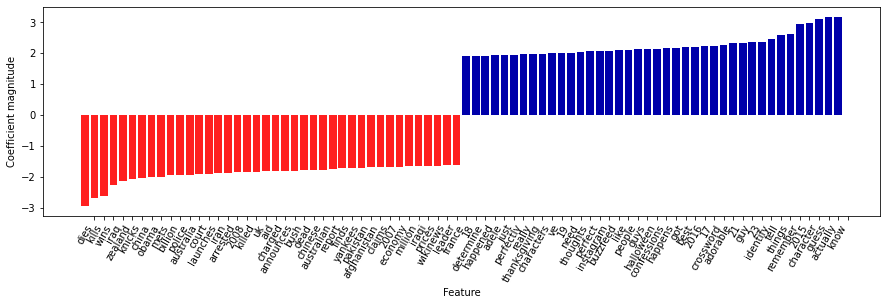

In [9]:
import mglearn
coef = logit_1.coef_
feature_names = np.array(countvect.get_feature_names())
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

#### Approach 2: Tf-Idf

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvect = TfidfVectorizer(min_df=3, norm=None, stop_words = 'english').fit(X_train)
X_tfidf_train = tfidfvect.transform(X_train)
X_tfidf_test = tfidfvect.transform(X_test)

In [11]:
logit_2 = LogisticRegression().fit(X_tfidf_train,y_train)
print("The Mean Cross Validation f1 Score for Tf-Idf approach is {:.2f}".format(np.mean(cross_val_score(logit_2, X_tfidf_train, y_train, cv=5, scoring='f1'))))
print("The test f1 score for Tf-Idf approach is {:.2f}".format(f1_score(logit_2.predict(X_tfidf_test),y_test)))

The Mean Cross Validation f1 Score for Tf-Idf approach is 0.94
The test f1 score for Tf-Idf approach is 0.94


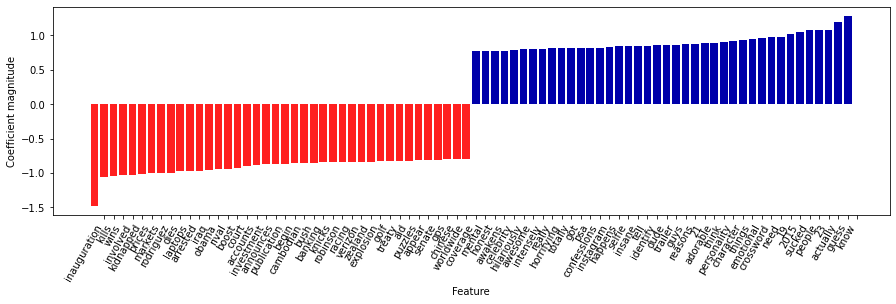

In [12]:
coef = logit_2.coef_
feature_names = np.array(tfidfvect.get_feature_names())
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

#### Approach 3: lemmatization

In [13]:
! pip install nltk

In [14]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

# nltk.download('punkt') # may need to updated nltk by downloading modules
# nltk.download('wordnet') # may need to updated nltk by downloading modules

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
# define a count vectorizer with the custom tokenizer

lemma_vect = CountVectorizer(tokenizer=LemmaTokenizer())  
lemma_vect.fit(X_train)
X_lem_train = lemma_vect.transform(X_train)
X_lem_test = lemma_vect.transform(X_test)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [15]:
logit_3 = LogisticRegression().fit(X_lem_train,y_train)
print("The Mean Cross Validation f1 Score for lemmatization approach is {:.2f}".format(np.mean(cross_val_score(logit_3, X_lem_train, y_train, cv=5, scoring='f1'))))
print("The test f1 score for lemmatization approach is {:.2f}".format(f1_score(logit_3.predict(X_lem_test),y_test)))

The Mean Cross Validation f1 Score for lemmatization approach is 0.97
The test f1 score for lemmatization approach is 0.98


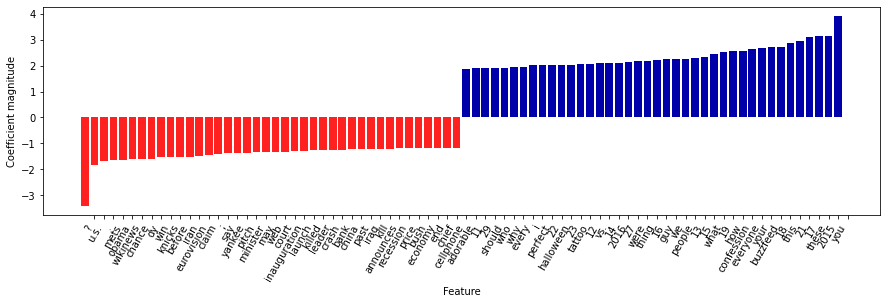

In [17]:
coef = logit_3.coef_
feature_names = np.array(lemma_vect.get_feature_names())
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

##### Conclusion of Question 1:
- the Mean Cross Validation f1 Score and test set f1 score are 0.95 for Bag-of-Words approach, 0.94 for tf-idf approach, 0.97 and 0.98 for lemmatization approach. Thus, lemmatization approach provide the best tokenization among these three.

### Part 2: Build a predictive neural network using Keras

In [18]:
import pandas as pd
import tensorflow.keras as keras
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv")

#update data to set up for train test split
data = data.iloc[:,1:]
y = LabelEncoder().fit_transform(data['Species'])
X = data.loc[:, data.columns != 'Species']

In [19]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#Include code for selecting the number of hidden units using GridSearchCV and evaluation on a test-set
def create_model(hiddenunits=8):
	# create model
	model = Sequential()
	model.add(Dense(hiddenunits, input_dim=4, activation='relu'))
	model.add(Dense(hiddenunits, activation='relu'))
	model.add(Dense(3, activation='sigmoid'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
	return model

model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

hiddenunits = [8, 12, 16, 20]

param_grid = dict(hiddenunits=hiddenunits) 

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.950000 using {'hiddenunits': 20}


In [24]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.metrics import accuracy_score

model = KerasClassifier(build_fn= lambda: create_model(8), epochs=100, verbose=0)
model.fit(X_train,y_train)
print(accuracy_score(y_test, model.predict(X_test)))

model = KerasClassifier(build_fn= lambda: create_model(12), epochs=100, verbose=0)
model.fit(X_train,y_train)
print(accuracy_score(y_test, model.predict(X_test)))

model = KerasClassifier(build_fn= lambda: create_model(16), epochs=100, verbose=0)
model.fit(X_train,y_train)
print(accuracy_score(y_test, model.predict(X_test)))

model = KerasClassifier(build_fn= lambda: create_model(20), epochs=100, verbose=0)
model.fit(X_train,y_train)
print(accuracy_score(y_test, model.predict(X_test)))

0.9
0.94
0.98
0.98


##### CONCLUSION FOR QUESTION 2
- According to the result of GridSearchCV, we can get the accurate prediction when there are 20 hiddenunits, the cross-validation score is 0.95. 
- The test-set evaluation shows that the accuracy is 0.9 for 8 hiddenunits, 0.94 for 12 hiddenunits, 0.98 for 16 hiddenunits, and 0.98 for 20 hiddenunits. 
- Taken the results of GridSearchCV and test-set evaluation into account, model with 20 hiddenunits always give the best accuracy, hence I choose the model with 20 hiddenunits